# Anomaly Detection For Images
#### In general, anomaly detection algorithms are trained on one type of data (Ex: images of cars), such that the model can accurately recognize that type of data (Ex: new car images) and recognize any other type of data as an anomaly (Ex: an image of a tree). In this case, the instances of anomalous data are near infinite.

#### Specifically for this application, anomaly detection algorithms have been trained on MRI scans of normal brains. From this, these algorithms can recognize normal brain scans and we can see how well the models perform at recognizing anomalous data, in this case MRI scans of tumorous brains.

#### In this notebook, we will utilize two anomaly detection algorithms, **One-Class SVM** and **Isolation Forest**

![Anomaly Detection Image](https://i2.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection.png?fit=1200%2C800&ssl=1)

In [1]:
# general packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# image loading, pre-trained CNN
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# anomaly detection
from sklearn import svm
from sklearn.ensemble import IsolationForest

# scaling and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# classification metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# The Data
#### The training data is comprised of only non-tumorous brain scan images from various kaggle datasets. The test data contains non-tumorous and tumorous brain scan images from the same datasets.

In [2]:
# load image paths from folders
train_path =  'MRIscans/Training/'
val_path = 'MRIscans/Validation/'
test_path = 'MRIscans/Testing/'

train_files = glob.glob(os.path.join(train_path, 'no_tumor_train', '*.*'))
val_files = glob.glob(os.path.join(val_path, 'no_tumor_val', '*.*'))

test_files_pos = glob.glob(os.path.join(test_path, 'tumor_test', '*.*'))
test_files_neg = glob.glob(os.path.join(test_path, 'no_tumor', '*.*'))
test_files = test_files_pos + test_files_neg

test_labels = np.array([0]*len(test_files_pos)+[1]*len(test_files_neg))

print(f'Number of training files: {len(train_files)}')
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

print(f'\nNumber of tumor images in test set: {len(test_files_pos)}')
print(f'Number of non-tumor images in test set: {len(test_files_neg)}')

Number of training files: 1841
Number of validation files: 399
Number of test files: 867

Number of tumor images in test set: 129
Number of non-tumor images in test set: 738


In [3]:
print(train_files[0])
print(val_files[0])
print(test_files[0])

MRIscans/Training/no_tumor_train\1 no.jpeg
MRIscans/Validation/no_tumor_val\Tr-no_0825.jpg
MRIscans/Testing/tumor_test\p (179).jpg


In [4]:
def read_and_prep_imgs(files):
    # load the images from the path with size 250x250
    imgs = [load_img(img_path, target_size=(250, 250)) for img_path in files]
    # convert list of images to numpy array
    dataset = np.array([img_to_array(img) for img in imgs])
    # appropriately preprocess images for resnet use
    dataset = preprocess_input(dataset)
    return dataset

In [5]:
train_dataset = read_and_prep_imgs(train_files)
val_dataset = read_and_prep_imgs(val_files)
test_dataset = read_and_prep_imgs(test_files)

print('Training Set:    ', train_dataset.shape)
print('Validation Set:  ', val_dataset.shape)
print('Testing Set:     ', test_dataset.shape)

Training Set:     (1841, 250, 250, 3)
Validation Set:   (399, 250, 250, 3)
Testing Set:      (867, 250, 250, 3)


# One-Class SVM & Isolation Forest For Images

## ResNet50 For Feature Extraction

#### In order to apply these anomaly detection algorithms for images, a pre-trained CNN model (ResNet50) was used to extract image features (with the fully-connected prediction layer dropped for feature extraction).
* 50 layer deep residual neural network (stacks residual blocks on top of each other to form a network)
* Surpasses the difficulties of training very deep neural networks with clever tricks
* Vanishing gradient problem
  * The gradient becomes smaller and smaller as it reaches the bottom of the network, therefore, the weights of the initial layers will either update very slowly or remains the same (the initial layers of the network won’t learn effectively)
  * As the number of layers of the neural network increases, the accuracy levels may get saturated and slowly degrade after a point; as a result, the performance of the model deteriorates both on the training and testing data
* Utilizes the concept of skip connections
  * Setting up an alternate shortcut for the gradient to pass through
  * Additionally enables the model to learn an identity function which ensures that the higher layers of the model do not perform any worse than the lower layers

![ResNet50 Architecture](https://www.researchgate.net/publication/331364877/figure/fig3/AS:741856270901252@1553883726825/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png)

In [6]:
# don't include top layer since that fully-conneccted layer is used for predictions
resnet_model = ResNet50(input_shape=(250,250,3), weights='imagenet', include_top=False, pooling='avg')

train_features = resnet_model.predict(train_dataset)
val_features = resnet_model.predict(val_dataset)
test_features = resnet_model.predict(test_dataset)

In [7]:
print('Train Features Length:', len(train_features))
print('Val Features Length:', len(val_features))
print('Test Features Length:', len(test_features))

Train Features Length: 1841
Val Features Length: 399
Test Features Length: 867


#### After scaling and reducing the dimensionality of such features, the one-class SVM and isolation forest algorithms were trained on the extracted features on the positive class images (non-tumorous brain scans) and then evaluated on the test set for anomaly detection.

In [8]:
# standardize the features vector
sc = StandardScaler()
sc.fit(train_features)
train_features_prep = sc.transform(train_features)
val_features_prep = sc.transform(val_features)
test_features_prep = sc.transform(test_features)

# reduce the dimensionality of the features vector
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(train_features_prep)
train_features_prep = pca.transform(train_features_prep)
val_features_prep = pca.transform(val_features_prep)
test_features_prep = pca.transform(test_features_prep)

print('Explained Variance {:.2%}'.format(sum(pca.explained_variance_ratio_)))

Explained Variance 97.88%


#### One-Class SVM
* Creates a non-linear decision boundary by projecting the data through a non-linear function $ \phi $ to a space with a higher dimension, therefore, data points which cannot be separated by a straight line in their original space *I* are lifted to a feature space *F* where a straight hyperplane can separate the data points of one class from another; when that hyperplane is projected back to the input space I, it would have the form of a non-linear curve
* Hyperplane, represented by $$ w^Tx+b=0 $$ where $ w \in F $ and $ b \in R $, searches for the maximal margin between the classes
* Objective function: $$ \min_{w, b, \xi_i} \frac{||w||^2}{2} + C \sum_{i=1}^n \xi_i $$ subject to $$ y_i(w^T \phi(x_i) + b) \ge 1 - \xi_i $$ $$ \xi_i \ge 0 $$ where 
  * $ \xi_i $ is the slack variable to allow some data points to lie within the margin
  * $ C $ is the coefficient determining the trade-off between maximizing the margin and the number of data points within the margin
* For the one-class case, SVM separates the data points from the origin (in feature space *F*) and maximizes the distance from this hyperplane to the origin
* Objective function: $$ \min_{w, \xi_i, \rho} \frac{1}{2} ||w||^2 + \frac{1}{vn} \sum_{i=1}^n \xi_i - \rho $$ subject to $$ (w \cdot \phi(x_i)) \ge \rho - \xi_i $$ $$ \xi_i \ge 0 $$ where
  * $ v $ sets an upper bound on the fraction of outliers and is a lower bound on the number of training examples used

#### Isolation Forest
* Builds an ensemble of binary trees for a given dataset
* The algorithm recursively generates partitions on the sample by randomly selecting an attribute and then randomly selecting a split value for the attribute, between the minimum and maximum values allowed for that attribute
* Anomalies, due to their nature, have the shortest path in these trees
* Anomaly score
$$ c(m) = \begin{cases}
    2H(m - 1) - \frac{2(m-1)}{n}    &\text{for m>2}\\
    1                               &\text{for m=2}\\
    0                               &\text{otherwise}    
\end{cases} $$
* where, 
  * $ n $ is the testing data size
  * $ m $ is the size of the sample set
  * $ H $ is the harmonic number $ H(i) = ln(i) + \gamma  $

In [9]:
# anomaly detection algorithms
# TODO: hyper-parameter tuning on val set
oneclass_svm = svm.OneClassSVM(kernel='rbf')
iso_forest = IsolationForest(n_estimators=100)

oneclass_svm.fit(train_features_prep)
iso_forest.fit(train_features_prep)

oneclass_svm_preds = oneclass_svm.predict(test_features_prep)
iso_forest_preds = iso_forest.predict(test_features_prep)

In [10]:
# since the model is trained on exclusively non-tumorous brain scans,
# 0 indicates tumorous (anomaly), 1 indicates non-tumorous (normal)
oneclass_svm_preds = [0 if x == -1 else 1 for x in oneclass_svm_preds]
iso_forest_preds = [0 if x == -1 else 1 for x in iso_forest_preds]
actual_class = [0 if file.find('tumor_test') != -1 else 1 for file in test_files]

svm_iso_results = pd.DataFrame({
  'path':               test_files,
  'oneclass_svm_preds': oneclass_svm_preds,
  'iso_forest_preds':   iso_forest_preds,
  'actual_class':       actual_class
})

svm_iso_results

,path,oneclass_svm_preds,iso_forest_preds,actual_class
0,MRIscans/Testing/tumor_test\p (179).jpg,0,1,0
1,MRIscans/Testing/tumor_test\p (180).jpg,0,0,0
2,MRIscans/Testing/tumor_test\p (181).jpg,0,0,0
3,MRIscans/Testing/tumor_test\p (182).jpg,0,0,0
4,MRIscans/Testing/tumor_test\p (183).jpg,0,0,0
...,...,...,...,...
862,MRIscans/Testing/no_tumor\Tr-no_1590.jpg,1,1,1
863,MRIscans/Testing/no_tumor\Tr-no_1591.jpg,1,1,1
864,MRIscans/Testing/no_tumor\Tr-no_1592.jpg,1,1,1
865,MRIscans/Testing/no_tumor\Tr-no_1593.jpg,0,1,1


--One-Class SVM Evaluation--
ROC-AUC Score: 0.7940379403794038
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       129
           1       1.00      0.59      0.74       738

    accuracy                           0.65       867
   macro avg       0.65      0.79      0.60       867
weighted avg       0.90      0.65      0.70       867



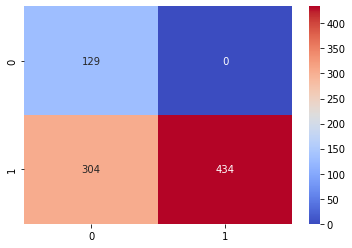

In [11]:
print('--One-Class SVM Evaluation--')
print('ROC-AUC Score:', roc_auc_score(actual_class, oneclass_svm_preds))
print('Classification Report:')
print(classification_report(actual_class, oneclass_svm_preds))
sns.heatmap(confusion_matrix(actual_class, oneclass_svm_preds), annot=True, fmt = '2.0f', cmap='coolwarm')
plt.show()

> One-class SVM does a very good job at classifying anomalous data, but not that good of a job at classifying normal data

--Isolation Forest Evaluation--
ROC-AUC Score: 0.609015566899855
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.22      0.36       129
           1       0.88      0.99      0.93       738

    accuracy                           0.88       867
   macro avg       0.87      0.61      0.64       867
weighted avg       0.88      0.88      0.85       867



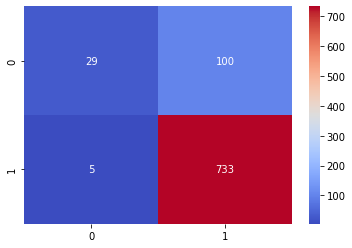

In [12]:
print('--Isolation Forest Evaluation--')
print('ROC-AUC Score:', roc_auc_score(actual_class, iso_forest_preds))
print('Classification Report:')
print(classification_report(actual_class, iso_forest_preds))
sns.heatmap(confusion_matrix(actual_class, iso_forest_preds), annot=True, fmt = '2.0f', cmap='coolwarm')
plt.show()

> Isolation Forest does a very good job at classifying normal data, but not that good of a job at classifying anomalous data

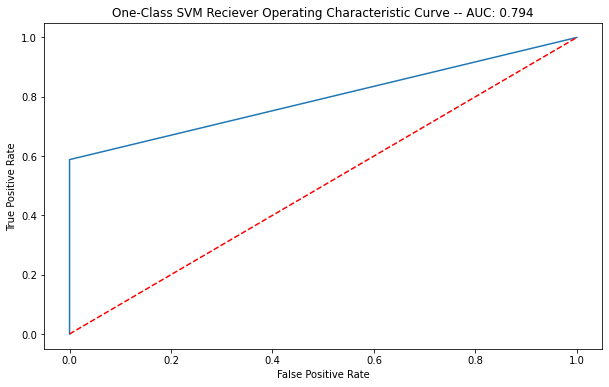

In [13]:
fpr, tpr, _ = roc_curve(actual_class, oneclass_svm_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'One-Class SVM Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
plt.show()

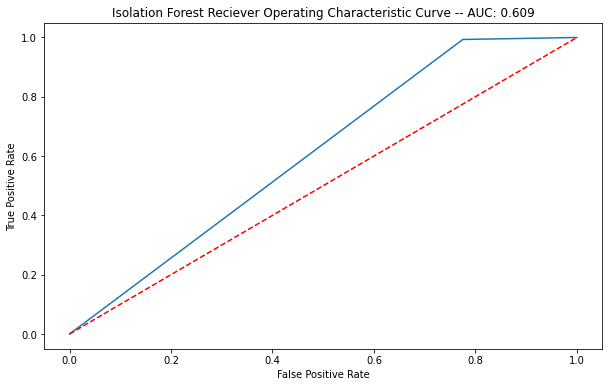

In [14]:
fpr, tpr, _ = roc_curve(actual_class, iso_forest_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'Isolation Forest Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
plt.show()